# Comparing Integrated Gradients and Activation Patching



## Set up

We load a pre-trained toy transformer which performs balanced bracket classification.

In [103]:
import importlib

import torch
from captum.attr import LayerIntegratedGradients
import numpy as np
from transformer_lens.utils import get_act_name

import toy_transformers.toy_bracket_transformer as tt
importlib.reload(tt)
from toy_transformers.toy_bracket_transformer import load_toy_bracket_transformer, test_loaded_bracket_model

import seaborn as sns
import matplotlib.pyplot as plt


In [104]:
tokenizer, model = load_toy_bracket_transformer()

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (hook_tokens): HookPoint()
  (blocks): ModuleList(
    (0-2): 3 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out):

## Integrated gradients

To calculate the importance of a neuron or an attention head in the model, we use Integrated Gradients (IG).
- For a neuron, we compute the attribution scores of the _inputs_ and project them by multiplying the attribution scores by the neuron's weight matrix. Neurons which focus on important inputs should have high importance scores.
- For an attention head, we compute the attribution scores of each attention head's _output_ and take those as the importance scores.

In [ ]:
def predict_unbalanced(x):
    logits = model(x)[:, 0]
    return logits.softmax(-1)[:, 0]


def compute_layer_to_output_attributions(target_layer, baseline, attribute_to_layer_input=False):
    ig_embed = LayerIntegratedGradients(predict_unbalanced, target_layer)
    # Calculate layer integrated gradients for class 0 (unbalanced),
    attributions, approximation_error = ig_embed.attribute(inputs=input,
                                                    baselines=baseline,
                                                    attribute_to_layer_input=attribute_to_layer_input,
                                                    return_convergence_delta=True)
    print(f"\nError (delta) for {target_layer.name} attribution: {approximation_error.item()}")
    return attributions


def project_input_importance(layer_id, attributions):
    # Compute MLP neuron importance by projection
    w_in = model.blocks[layer_id].mlp.W_in
    b_in = model.blocks[layer_id].mlp.b_in
    importance = torch.nn.functional.relu((attributions @ w_in.T) + b_in)
    print(importance.shape)
    return importance

Set the baseline as a sequence of padding tokens except for start/end tokens:
1. Padding tokens (PAD_TOKEN) represent "no information" in the model's embedding space
2. We preserve start/end tokens to maintain the sequence structure
3. This creates a neutral reference point that only differs from the input in meaningful bracket positions. The attribution will then show how each bracket contributes relative to "no bracket"

In [303]:
# Gradient attribution for neurons in MLP layers
mlp_ig_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Gradient attribution for attention heads
attn_ig_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

# Calculate integrated gradients for each layer
input = tokenizer.tokenize("()()")
mask = np.isin(input, [tokenizer.START_TOKEN, tokenizer.END_TOKEN])
baseline = input * mask + tokenizer.PAD_TOKEN * (1 - mask)

for layer in range(model.cfg.n_layers):
    # Gradient attribution on heads
    hook_name = get_act_name("result", layer)
    target_layer = model.hook_dict[hook_name]
    attributions = compute_layer_to_output_attributions(target_layer, baseline)
    # Calculate attribution score based on mean over each embedding, for each token
    per_token_score = attributions.mean(dim=3)
    score = per_token_score.mean(dim=1)
    attn_ig_results[layer] = score

    # Gradient attribution on MLP neurons
    target_layer = model.blocks[layer].mlp
    attributions = compute_layer_to_output_attributions(target_layer, baseline, attribute_to_layer_input=True)
    attributions = project_input_importance(layer, attributions)
    score = attributions.mean(dim=1)
    mlp_ig_results[layer] = score


Error (delta) for blocks.0.attn.hook_result attribution: 0.06377953290939331

Error (delta) for blocks.0.mlp attribution: -0.00153428316116333
torch.Size([1, 6, 56])

Error (delta) for blocks.1.attn.hook_result attribution: 0.1287258267402649

Error (delta) for blocks.1.mlp attribution: 0.021128416061401367
torch.Size([1, 6, 56])

Error (delta) for blocks.2.attn.hook_result attribution: 0.00042438507080078125

Error (delta) for blocks.2.mlp attribution: 0.999981701374054
torch.Size([1, 6, 56])


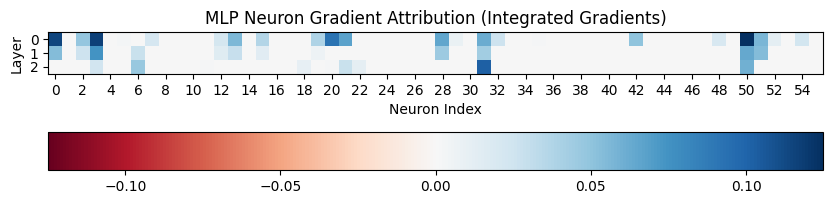

In [304]:
bound = max(torch.max(mlp_ig_results), abs(torch.min(mlp_ig_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_ig_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients)")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

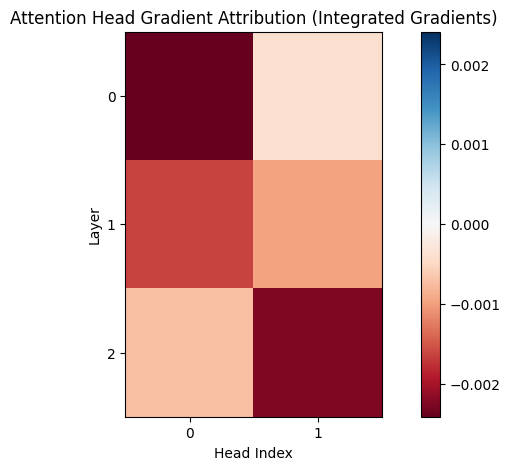

In [244]:
bound = max(torch.max(attn_ig_results), abs(torch.min(attn_ig_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_ig_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients)")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

### Comparison: unbalanced input sequence

Repeat with unbalanced sequence for comparison.

In [290]:
# Gradient attribution for neurons in MLP layers
mlp_ig_unbalanced_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Gradient attribution for attention heads
attn_ig_unbalanced_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

# Calculate integrated gradients for each layer
input = tokenizer.tokenize("(()(")
mask = np.isin(input, [tokenizer.START_TOKEN, tokenizer.END_TOKEN])
baseline = input * mask + tokenizer.PAD_TOKEN * (1 - mask)

for layer in range(model.cfg.n_layers):
    # Gradient attribution on heads
    hook_name = get_act_name("result", layer)
    target_layer = model.hook_dict[hook_name]
    attributions = compute_layer_to_output_attributions(target_layer, baseline)
    # Calculate attribution score based on mean over each embedding, for each token
    per_token_score = attributions.mean(dim=3)
    score = per_token_score.mean(dim=1)
    attn_ig_unbalanced_results[layer] = score

    # Gradient attribution on MLP neurons
    target_layer = model.blocks[layer].mlp
    attributions = compute_layer_to_output_attributions(target_layer, baseline, attribute_to_layer_input=True)
    attributions = project_input_importance(layer, attributions)
    score = attributions.mean(dim=1)
    mlp_ig_unbalanced_results[layer] = score


Error (delta) for blocks.0.attn.hook_result attribution: 1.1101647032774054e-06

Error (delta) for blocks.0.mlp attribution: 1.4039926099940203e-05
torch.Size([1, 6, 56])

Error (delta) for blocks.1.attn.hook_result attribution: 4.682117832999211e-06

Error (delta) for blocks.1.mlp attribution: 3.1640593078918755e-05
torch.Size([1, 6, 56])

Error (delta) for blocks.2.attn.hook_result attribution: 3.125926377833821e-05

Error (delta) for blocks.2.mlp attribution: 1.8802118574967608e-05
torch.Size([1, 6, 56])


Gradient attribution scores for MLP neurons do not depend on whether the sequence is balanced or unbalanced. This suggests that the MLP neurons may be involved in some universal processing of information, used downstream for final output classification.

Gradient attribution scores for attention heads change when the sequence is unbalanced. Notably, head 2.1 contributes significantly more highly to a positive "unbalanced" classification. This suggests that head 2.1 plays a strong role in the final output. The attribution scores for the other attention heads are less strong, suggesting a weaker role.

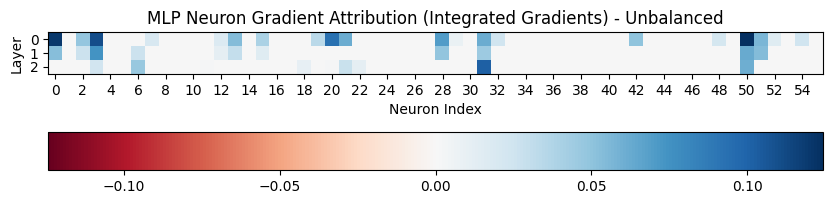

In [261]:
bound = max(torch.max(mlp_ig_unbalanced_results), abs(torch.min(mlp_ig_unbalanced_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_ig_unbalanced_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Gradient Attribution (Integrated Gradients) - Unbalanced")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

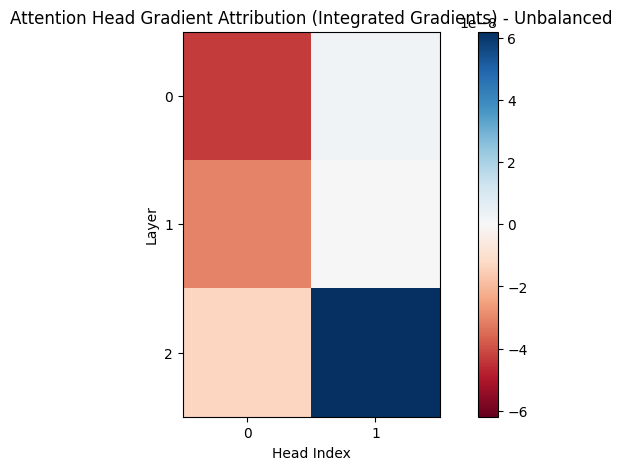

In [248]:
bound = max(torch.max(attn_ig_unbalanced_results), abs(torch.min(attn_ig_unbalanced_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_ig_unbalanced_results.detach(), cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Gradient Attribution (Integrated Gradients) - Unbalanced")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

## Causal tracing

We use activation patching to identify the most important neurons and attention heads in the toy transformer model.

In [ ]:
from transformer_lens import HookedTransformer, ActivationCache
from transformer_lens.hook_points import HookPoint

clean_input = tokenizer.tokenize("()()")        # Balanced
corrupted_input = tokenizer.tokenize("(()(")    # Unbalanced

# We run on the clean prompt with the cache so we store activations to patch in later.
clean_logits, clean_cache = model.run_with_cache(clean_input)
corrupted_logits = model(corrupted_input)

# Get probability of overall sequence being unbalanced (class 0)
clean_answer_logits = clean_logits[0, -1, 0]
corrupted_answer_logits = corrupted_logits[0, -1, 0]
print(f"Balanced input score: {clean_answer_logits}")
print(f"Unbalanced input score: {corrupted_answer_logits}")

baseline_diff = (clean_answer_logits - corrupted_answer_logits).item()
print(f"Baseline clean-corrupted logit difference: {baseline_diff:.2f}")

Balanced input score: -1.447350025177002
Unbalanced input score: 4.6780781745910645
Baseline clean-corrupted logit difference: -6.13


In [50]:
print(clean_cache["blocks.0.attn.hook_result"].shape)
clean_cache["blocks.0.hook_mlp_out"].shape

torch.Size([1, 6, 2, 56])


torch.Size([1, 6, 56])

In [293]:
# Patch neurons in MLP layers
mlp_patch_results = torch.zeros(model.cfg.n_layers, model.cfg.d_mlp)
# Patch attention heads
attn_patch_results = torch.zeros(model.cfg.n_layers, model.cfg.n_heads)

def patch_neuron_hook(activations: torch.Tensor, hook: HookPoint, clean_cache: ActivationCache, neuron_idx: int):
    # Replace the activations for the target neuron with activations from the clean run.
    clean_activations = clean_cache[hook.name]
    activations[:, :, neuron_idx] = clean_activations[:, :, neuron_idx]
    return activations

def patch_attn_hook(activations: torch.Tensor, hook: HookPoint, clean_cache: ActivationCache, head_idx: int):
    # Replace the activations for the target attention head with activations from the clean run.
    clean_activations = clean_cache[hook.name]
    activations[:, :, head_idx, :] = clean_activations[:, :, head_idx, :]
    return activations


for layer in range(model.cfg.n_layers):
    # Activation patching on heads
    for head in range(model.cfg.n_heads):
        hook_name = get_act_name("result", layer)
        temp_hook = lambda act, hook: patch_attn_hook(act, hook, clean_cache, head)

        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(corrupted_input)

        patched_answer_logits = patched_logits[0, -1, 0]
        logit_diff = (patched_answer_logits - corrupted_answer_logits).item()
        # Normalise result by clean and corrupted logit difference
        attn_patch_results[layer, head] = logit_diff / baseline_diff

    # Activation patching on MLP neurons
    for neuron in range(model.cfg.d_mlp):
        hook_name = get_act_name("mlp_out", layer)
        temp_hook = lambda act, hook: patch_neuron_hook(act, hook, clean_cache, neuron)
        
        with model.hooks(fwd_hooks=[(hook_name, temp_hook)]):
            patched_logits = model(corrupted_input)

        patched_answer_logits = patched_logits[0, -1, 0]
        logit_diff = (patched_answer_logits - corrupted_answer_logits).item()
        # Normalise result by clean and corrupted logit difference
        mlp_patch_results[layer, neuron] = logit_diff / baseline_diff

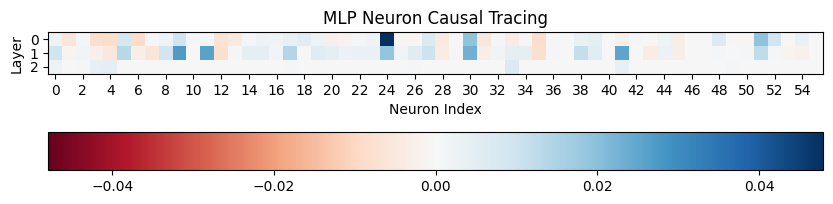

In [294]:
bound = max(torch.max(mlp_patch_results), abs(torch.min(mlp_patch_results)))

plt.figure(figsize=(10, 5))
plt.imshow(mlp_patch_results, cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("MLP Neuron Causal Tracing")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.colorbar(orientation="horizontal")
plt.show()

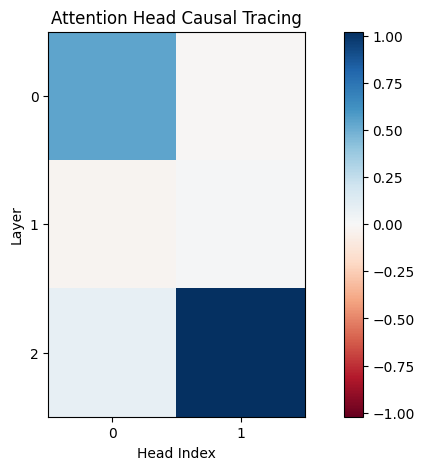

In [67]:
bound = max(torch.max(attn_patch_results), abs(torch.min(attn_patch_results)))

plt.figure(figsize=(10, 5))
plt.imshow(attn_patch_results, cmap='RdBu', vmin=-bound, vmax=bound)
plt.title("Attention Head Causal Tracing")

plt.xlabel("Head Index")
plt.xticks([0,1])

plt.ylabel("Layer")
plt.yticks([0,1,2])

plt.colorbar()
plt.show()

## Analysis

In [306]:
mlp_ig_results = mlp_ig_results.detach()
attn_ig_results = attn_ig_results.detach()

### Correlation between attribution scores

* There is very little linear correlation between raw attribution scores for MLP neurons from Integrated Gradients and causal tracing.

Text(0, 0.5, 'Causal Tracing Attribution Scores')

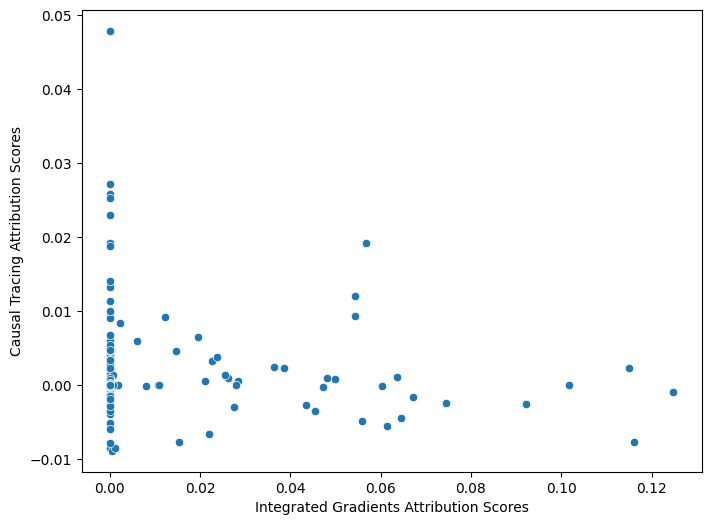

In [ ]:
# Plot the attribution scores against each other. Correlation: y = x.

plt.figure(figsize=(8,6))
sns.scatterplot(x=mlp_ig_results.flatten(), y=mlp_patch_results.flatten())
plt.xlabel("Integrated Gradients MLP Attribution Scores")
plt.ylabel("Causal Tracing MLP Attribution Scores")

Text(0, 0.5, 'Causal Tracing Attention Attribution Scores')

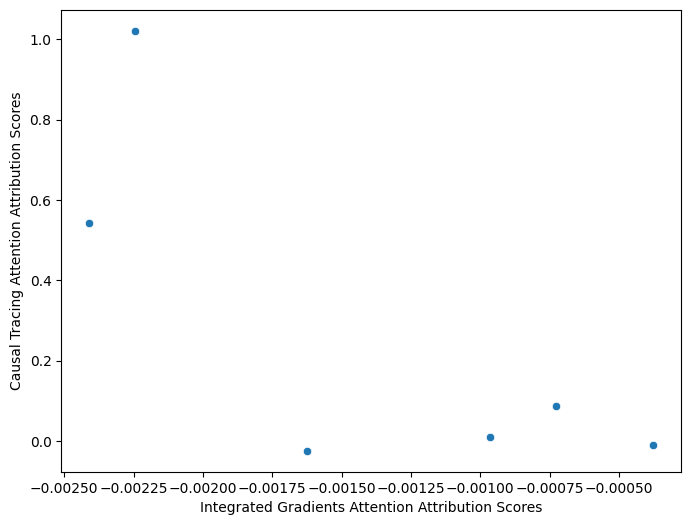

In [298]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=attn_ig_results.flatten(), y=attn_patch_results.flatten())
plt.xlabel("Integrated Gradients Attention Attribution Scores")
plt.ylabel("Causal Tracing Attention Attribution Scores")

### Agreement between attribution scores

The Jaccard scores for MLP neuron attribution scores per transformer layer is low.

In [322]:
def get_top_k_by_abs(data, k):
    _, indices = torch.topk(data.abs(), k)
    return indices, torch.gather(data, 1, indices)

top_mlp_ig_indices, top_mlp_ig_results = get_top_k_by_abs(mlp_ig_results, 20)
top_mlp_patch_indices, top_mlp_patch_results = get_top_k_by_abs(mlp_patch_results, 20)

In [343]:
top_mlp_ig_sets = [set(row.tolist()) for row in top_mlp_ig_indices]
top_mlp_patch_sets = [set(row.tolist()) for row in top_mlp_patch_indices]
mlp_intersections, mlp_unions, mlp_jaccards = [], [], []
for s1, s2 in zip(top_mlp_ig_sets, top_mlp_patch_sets):
    intersection = s1.intersection(s2)
    union = s1.union(s2)
    jaccard = len(intersection) / len(union)

    mlp_intersections.append(intersection)
    mlp_unions.append(union)
    mlp_jaccards.append(jaccard)


print(f"Jaccard score for MLP neurons per layer: {mlp_jaccards}")

Jaccard score for MLP neurons per layer: [0.25, 0.17647058823529413, 0.25]


In [345]:
def indices_set_to_binary_matrix(indices_sets, shape):
    binary_mat = torch.zeros(shape, dtype=torch.long)
    for row_idx, indices in enumerate([list(s) for s in indices_sets]):
        binary_mat[row_idx, indices] = 1
    return binary_mat

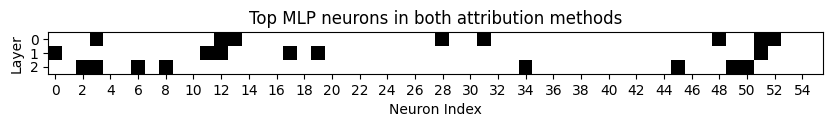

In [346]:
binary_mat_intersections = indices_set_to_binary_matrix(mlp_intersections, mlp_ig_results.shape)

plt.figure(figsize=(10, 8))
plt.imshow(binary_mat_intersections, cmap="Greys")
plt.title("Top MLP neurons in both attribution methods")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.show()

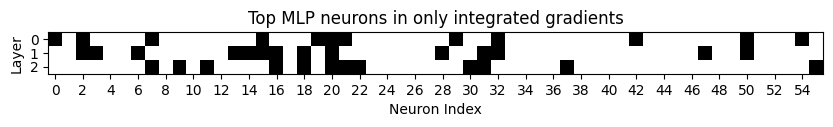

In [349]:
top_mlp_ig_exclusive = [s1.difference(s2) for s1, s2 in zip(top_mlp_ig_sets, top_mlp_patch_sets)]

binary_mat_ig_exclusive = indices_set_to_binary_matrix(top_mlp_ig_exclusive, mlp_ig_results.shape)

plt.figure(figsize=(10, 8))
plt.imshow(binary_mat_ig_exclusive, cmap="Greys")
plt.title("Top MLP neurons in only integrated gradients")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.show()

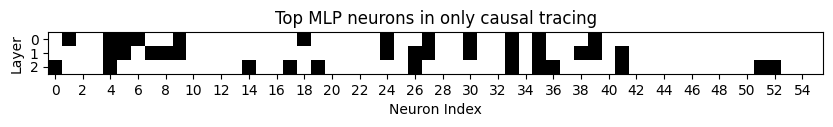

In [348]:
top_mlp_patch_exclusive = [s1.difference(s2) for s1, s2 in zip(top_mlp_patch_sets, top_mlp_ig_sets)]

binary_mat_patch_exclusive = indices_set_to_binary_matrix(top_mlp_patch_exclusive, mlp_patch_results.shape)

plt.figure(figsize=(10, 8))
plt.imshow(binary_mat_patch_exclusive, cmap="Greys")
plt.title("Top MLP neurons in only causal tracing")
plt.xticks(np.arange(0, 56, 2))
plt.xlabel("Neuron Index")
plt.yticks([0,1,2])
plt.ylabel("Layer")
plt.show()